In [16]:
import numpy as np
import csv
import pandas as pd
import time
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import scale
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR_PATH = '.\data\\'
TRAIN_FILE = DATA_DIR_PATH + 'training.csv'
TEST_FILE = DATA_DIR_PATH + 'test.csv'

### Print the Train Dataset

In [3]:
result = np.array(list(csv.reader(open(TRAIN_FILE, "r"), delimiter=","))).astype("str")

In [4]:
result = np.char.upper(result)
result

array([['REFID', 'ISBADBUY', 'PURCHDATE', ..., 'VEHBCOST', 'ISONLINESALE',
        'WARRANTYCOST'],
       ['1', '0', '12/7/2009', ..., '7100', '0', '1113'],
       ['2', '0', '12/7/2009', ..., '7600', '0', '1053'],
       ..., 
       ['73012', '0', '12/2/2009', ..., '8200', '0', '1893'],
       ['73013', '0', '12/2/2009', ..., '7000', '0', '1974'],
       ['73014', '0', '12/2/2009', ..., '8000', '0', '1313']], 
      dtype='<U33')

In [5]:
y = result[1:,1:2]
y

array([['0'],
       ['0'],
       ['0'],
       ..., 
       ['0'],
       ['0'],
       ['0']], 
      dtype='<U33')

### Print the number of examples of the 2 different classes

In [6]:
unique, counts = np.unique(y, return_counts=True)
lbl_counts = dict(zip(unique, counts))
lbl_counts

{'0': 64007, '1': 8976}

### As seen below, This is Heavily Biased DataSet ! 87.7% belong to Class 0 and just 12.3% belong to Class 1

In [7]:
#Data is Biased towards good cars
print (lbl_counts['0'] / (lbl_counts['0'] + lbl_counts['1']))
print (lbl_counts['1'] / (lbl_counts['0'] + lbl_counts['1']))

0.877012454955
0.122987545045


### Remove the 2nd column ( Target label column), first row to make Train Matrix ready

In [8]:
X = np.delete(result,1,axis=1)
X = X[1:,1:]
X

array([['12/7/2009', 'ADESA', '2006', ..., '7100', '0', '1113'],
       ['12/7/2009', 'ADESA', '2004', ..., '7600', '0', '1053'],
       ['12/7/2009', 'ADESA', '2005', ..., '4900', '0', '1389'],
       ..., 
       ['12/2/2009', 'ADESA', '2005', ..., '8200', '0', '1893'],
       ['12/2/2009', 'ADESA', '2006', ..., '7000', '0', '1974'],
       ['12/2/2009', 'ADESA', '2006', ..., '8000', '0', '1313']], 
      dtype='<U33')

### Preprocess the Train Dataset :
#### 1. Convert Dates to epoch times (Integer time)
#### 2. Convert Categories in Strings to IDs
#### 3. Replace Continous missing values by their mean
#### 4. Replace Categorical missing values by a new ID
#### 5. Convert to Zero Mean and Equal Variance
#### 6. Remove the ID column. It is of no use

In [9]:
def category_to_int(column):
    unique = np.unique(column)
    return {k : v for v, k in enumerate(unique)}

In [10]:
def convert_to_epoch(dates):    
    res = []    
    pattern = '%m/%d/%Y'    
    return np.array([int(time.mktime(time.strptime(date[0], pattern))) for date in dates])


In [11]:
def integerize_feature(col, cat_int):
    total = len(col)
    for i in range(total):
        col[i] = cat_int[ col[i][0] ]
    return col

In [12]:
X[:,0:1] = convert_to_epoch(X[:,0:1]).reshape(len(X[:,0:1]),1)

cat_int = category_to_int(X[:,1:2])
X[:,1:2] = integerize_feature(X[:,1:2],cat_int).reshape(len(X[:,1:2]),1)

cat_int = category_to_int(X[:,4:5])
X[:,4:5] = integerize_feature(X[:,4:5],cat_int).reshape(len(X[:,4:5]),1)

cat_int = category_to_int(X[:,5:6])
X[:,5:6] = integerize_feature(X[:,5:6],cat_int).reshape(len(X[:,5:6]),1)

cat_int = category_to_int(X[:,6:7])
X[:,6:7] = integerize_feature(X[:,6:7],cat_int).reshape(len(X[:,6:7]),1)

cat_int = category_to_int(X[:,7:8])
X[:,7:8] = integerize_feature(X[:,7:8],cat_int).reshape(len(X[:,7:8]),1)

cat_int = category_to_int(X[:,8:9])
X[:,8:9] = integerize_feature(X[:,8:9],cat_int).reshape(len(X[:,8:9]),1)

cat_int = category_to_int(X[:,9:10])
X[:,9:10] = integerize_feature(X[:,9:10],cat_int).reshape(len(X[:,9:10]),1)

cat_int = category_to_int(X[:,11:12])
X[:,11:12] = integerize_feature(X[:,11:12],cat_int).reshape(len(X[:,11:12]),1)

cat_int = category_to_int(X[:,13:14])
X[:,13:14] = integerize_feature(X[:,13:14],cat_int).reshape(len(X[:,13:14]),1)

cat_int = category_to_int(X[:,14:15])
X[:,14:15] = integerize_feature(X[:,14:15],cat_int).reshape(len(X[:,14:15]),1)

cat_int = category_to_int(X[:,15:16])
X[:,15:16] = integerize_feature(X[:,15:16],cat_int).reshape(len(X[:,15:16]),1)

cat_int = category_to_int(X[:,24:25])
X[:,24:25] = integerize_feature(X[:,24:25],cat_int).reshape(len(X[:,24:25]),1)

cat_int = category_to_int(X[:,25:26])	
X[:,25:26] = integerize_feature(X[:,25:26],cat_int).reshape(len(X[:,25:26]),1)

cat_int = category_to_int(X[:,28:29])
X[:,28:29] = integerize_feature(X[:,28:29],cat_int).reshape(len(X[:,28:29]),1)


In [13]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
new_X = pd.to_numeric(X.reshape(-1, ), errors='coerce').reshape(X.shape)
X_imp = imp.fit_transform(new_X)
X_imp = scale(X_imp)
print (X_imp)

[[-0.16188038 -1.57821986  0.37946651 ...,  0.20876712 -0.16104504
  -0.27316186]
 [-0.16188038 -1.57821986 -0.77577499 ...,  0.49159905 -0.16104504
  -0.37335512]
 [-0.16188038 -1.57821986 -0.19815424 ..., -1.03569339 -0.16104504
   0.18772712]
 ..., 
 [-0.1856221  -1.57821986 -0.19815424 ...,  0.83099737 -0.16104504
   1.0293505 ]
 [-0.1856221  -1.57821986  0.37946651 ...,  0.15220073 -0.16104504
   1.16461139]
 [-0.1856221  -1.57821986  0.37946651 ...,  0.7178646  -0.16104504
   0.06081566]]


### Visualize the data using PCA with first 2 Principal Components

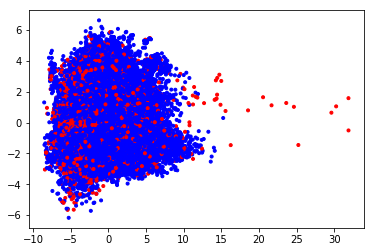

In [14]:
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
%matplotlib inline  

pca = decomposition.PCA(n_components=2)
pca.fit(X_imp)
X_pca = pca.transform(X_imp)
pyplot.scatter(X_pca[:,0:1], X_pca[:,1:2], marker='.', c=['B' if x[0]=='0' else 'R' for x in y])

### Measure 10-fold cross validation Accuracy of Logistic Regression and Naive Bayes

In [15]:
def do_cross_validation(X, y, clf, n_folds=10, verbose=False):

    accuracies = []
    cv = KFold(len(y), n_folds)
    for train_idx, test_idx in cv:        
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        accuracies.append(acc)                
    avg = np.mean(accuracies)
    return avg

In [19]:
print ('Logistic Regression', do_cross_validation(X_imp, y,LogisticRegression(), n_folds=10, verbose=False) * 100,'%')
print ('Naive Bayes', do_cross_validation(X_imp, y,GaussianNB(), n_folds=10, verbose=False) * 100,'%')

Logistic Regression 89.403008765 %
Naive Bayes 71.2302587766 %


### As seen above, LR has a validation accuracy of 89.4%. Let's fit the model and try it out on test Data

In [20]:
clf = LogisticRegression()
clf.fit(X_imp,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Read the Test Data, PreProcess it  according to 5 points mentioned during preprocessing train Data

In [21]:
result = np.array(list(csv.reader(open(TEST_FILE, "r"), delimiter=","))).astype("str")
result = np.char.upper(result)
result

array([['REFID', 'PURCHDATE', 'AUCTION', ..., 'VEHBCOST', 'ISONLINESALE',
        'WARRANTYCOST'],
       ['73015', '12/2/2009', 'ADESA', ..., '6500', '0', '2152'],
       ['73016', '12/2/2009', 'ADESA', ..., '6300', '0', '1118'],
       ..., 
       ['121744', '11/17/2010', 'MANHEIM', ..., '6335', '0', '594'],
       ['121745', '11/17/2010', 'MANHEIM', ..., '8055', '0', '1038'],
       ['121746', '11/17/2010', 'MANHEIM', ..., '7755', '0', '5392']], 
      dtype='<U33')

In [22]:
X_test = result[1:,1:]
X_test[:,0:1] = convert_to_epoch(X_test[:,0:1]).reshape(len(X_test[:,0:1]),1)

cat_int = category_to_int(X_test[:,1:2])
X_test[:,1:2] = integerize_feature(X_test[:,1:2],cat_int).reshape(len(X_test[:,1:2]),1)

cat_int = category_to_int(X_test[:,4:5])
X_test[:,4:5] = integerize_feature(X_test[:,4:5],cat_int).reshape(len(X_test[:,4:5]),1)

cat_int = category_to_int(X_test[:,5:6])
X_test[:,5:6] = integerize_feature(X_test[:,5:6],cat_int).reshape(len(X_test[:,5:6]),1)

cat_int = category_to_int(X_test[:,6:7])
X_test[:,6:7] = integerize_feature(X_test[:,6:7],cat_int).reshape(len(X_test[:,6:7]),1)

cat_int = category_to_int(X_test[:,7:8])
X_test[:,7:8] = integerize_feature(X_test[:,7:8],cat_int).reshape(len(X_test[:,7:8]),1)

cat_int = category_to_int(X_test[:,8:9])
X_test[:,8:9] = integerize_feature(X_test[:,8:9],cat_int).reshape(len(X_test[:,8:9]),1)

cat_int = category_to_int(X_test[:,9:10])
X_test[:,9:10] = integerize_feature(X_test[:,9:10],cat_int).reshape(len(X_test[:,9:10]),1)

cat_int = category_to_int(X_test[:,11:12])
X_test[:,11:12] = integerize_feature(X_test[:,11:12],cat_int).reshape(len(X_test[:,11:12]),1)

cat_int = category_to_int(X_test[:,13:14])
X_test[:,13:14] = integerize_feature(X_test[:,13:14],cat_int).reshape(len(X_test[:,13:14]),1)

cat_int = category_to_int(X_test[:,14:15])
X_test[:,14:15] = integerize_feature(X_test[:,14:15],cat_int).reshape(len(X_test[:,14:15]),1)

cat_int = category_to_int(X_test[:,15:16])
X_test[:,15:16] = integerize_feature(X_test[:,15:16],cat_int).reshape(len(X_test[:,15:16]),1)

cat_int = category_to_int(X_test[:,24:25])
X_test[:,24:25] = integerize_feature(X_test[:,24:25],cat_int).reshape(len(X_test[:,24:25]),1)

cat_int = category_to_int(X_test[:,25:26])
X_test[:,25:26] = integerize_feature(X_test[:,25:26],cat_int).reshape(len(X_test[:,25:26]),1)

cat_int = category_to_int(X_test[:,28:29])

X_test[:,28:29] = integerize_feature(X_test[:,28:29],cat_int).reshape(len(X_test[:,28:29]),1)
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
new_X_test = pd.to_numeric(X_test.reshape(-1, ), errors='coerce').reshape(X_test.shape)
X_imp_test = imp.fit_transform(new_X_test)
X_imp_test = scale(X_imp_test)
print (X_imp_test)

[[-0.26014819 -1.38418705 -0.19158447 ..., -0.14847128 -0.15001487
   1.42303744]
 [-0.26014819 -1.38418705 -0.19158447 ..., -0.26230061 -0.15001487
  -0.2665141 ]
 [-0.26014819 -1.38418705  0.38628925 ...,  1.67279798 -0.15001487
  -0.10801652]
 ..., 
 [ 1.39748936  0.15894865  0.38628925 ..., -0.24238048 -0.15001487
  -1.12272784]
 [ 1.39748936  0.15894865 -0.19158447 ...,  0.73655175 -0.15001487
  -0.39723376]
 [ 1.39748936  0.15894865 -1.34733192 ...,  0.56580775 -0.15001487
   6.71718348]]


In [23]:
clf.predict(X_imp_test)

array(['0', '0', '0', ..., '0', '0', '0'], 
      dtype='<U33')

### Conclusion:
#### Validation accuracy for Logistic Regression is 89.4% and Naive Bayes is 71.23%

### Future Work:
#### 1. The DataSet is Heavily Biased. Should try to balance the dataset, by including equal number of training examples for both classes
#### 2. Visualize the correlation between features and target Values
#### 3. Try approaches such as Bagging
#### 4. Here only accuracy has been measured. Try other metrics such as F1- Measure, AUC etc
#### 5. For models such as SVM, carefully finetune Hyper-params by Varying 'C' value, and try other kernels such as poly kernel